# Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd

In [5]:
import re

In [6]:
import pprint

In [7]:
import nltk

In [8]:
import pickle

In [9]:
import string

In [10]:
import numpy as np

In [11]:
from keras.utils.np_utils import to_categorical

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, accuracy_score, plot_confusion_matrix

In [13]:
from google.colab import files

# Data Reading

In [14]:
#since we're using google colab to run the files, we can import the data after an upload
uploaded = files.upload()

Saving us_election_2020_1st_presidential_debate.csv to us_election_2020_1st_presidential_debate (3).csv


In [15]:
df = pd.read_csv('us_election_2020_1st_presidential_debate.csv').drop('minute', axis=1)

# Test processing & Cleaning

In [16]:
def read_clean(text):
    '''
    Makes text lowercase, without punctuations, numbers removed and both numbers with letters next to it too.
    Input: 
        text: string type
    Output:
        text: a transformed string in lowercase, without punctuations etc.
    '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation),'', text)
    text = re.sub('w*\d\w', '', text)
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [17]:
df['text'] = df['text'].apply(read_clean)
df

,speaker,text
0,Chris Wallace,good evening from the health education campus ...
1,Chris Wallace,this debate is being conducted under health an...
2,Vice President Joe Biden,how you doing man
3,President Donald J. Trump,how are you doing
4,Vice President Joe Biden,i m well
...,...,...
784,Chris Wallace,gentlemen just say that s the end of it crosst...
785,President Donald J. Trump,i want to see an honest ballot count
786,Chris Wallace,we re going to leave it there
787,President Donald J. Trump,and i think he does too


# Target Counts

In [18]:
df['speaker'] = df['speaker'].apply(lambda x: x.replace(':', ''))

In [19]:
instances = df['speaker'].value_counts()
instances

President Donald J. Trump    314
Vice President Joe Biden     249
Chris Wallace                226
Name: speaker, dtype: int64

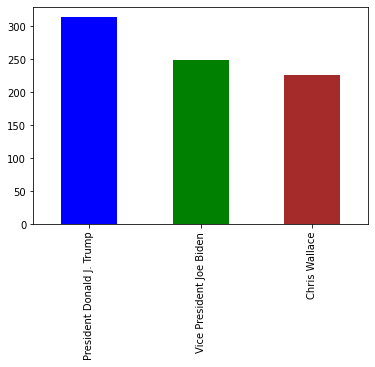

In [20]:
#visualize the speakers using a bar graph
instances.plot(kind='bar', color=['blue','green','brown']);

# Bench-Mark Model.

Lets start by defining a Keras Helper model that will be used to do the Model Building. 

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def keras_model():
    model = Sequential()
    model.add(Dense(20, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## 1.1 Create the predictor variable Y

This will be the first instance of the model. Here, we just use the original Data as it is withoug perfoming any sampling techniques. 

In [22]:
unique_speakers = list(df['speaker'].unique())

In [23]:
y = to_categorical(df['speaker'].apply(lambda x: unique_speakers.index(x)))

## 1.2 Split to test train Split

In [24]:
train_x, test_x, train_y, test_y = train_test_split(df['text'], y, test_size=0.1)

## 1.3 Feature Engineering

 Using TfidfVectorizer

In [25]:
tf = TfidfVectorizer(min_df=0.01).fit(train_x)
train_x = tf.transform(train_x).toarray()
test_x = tf.transform(test_x).toarray()
    

## 1.5 Model Creation

In [26]:
train_x.shape

(710, 274)

In [27]:
model = keras_model()
model.fit(train_x, train_y, batch_size=1, epochs=5, validation_split=0.1)

Epoch 1/5
639/639 [==============================] - 1s 936us/step - loss: 1.0796 - accuracy: 0.4163 - val_loss: 1.0252 - val_accuracy: 0.5352
Epoch 2/5
639/639 [==============================] - 0s 773us/step - loss: 0.9482 - accuracy: 0.5884 - val_loss: 0.7986 - val_accuracy: 0.7324
Epoch 3/5
639/639 [==============================] - 1s 801us/step - loss: 0.7623 - accuracy: 0.6745 - val_loss: 0.6405 - val_accuracy: 0.7324
Epoch 4/5
639/639 [==============================] - 1s 786us/step - loss: 0.6806 - accuracy: 0.7136 - val_loss: 0.5807 - val_accuracy: 0.8028
Epoch 5/5
639/639 [==============================] - 1s 802us/step - loss: 0.5919 - accuracy: 0.7512 - val_loss: 0.5299 - val_accuracy: 0.8028


In [28]:
preds = model.predict(test_x).argmax(axis=1)
preds

array([2, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2,
       2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0,
       2, 1, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 1])

In [29]:
accuracy_score(test_y.argmax(axis=1), preds)

0.7974683544303798

In [30]:
f1_score(test_y.argmax(axis=1), preds, average='micro')

0.7974683544303798

In [31]:
cm = pd.DataFrame(confusion_matrix(test_y.argmax(axis=1), preds), columns = unique_speakers, index= unique_speakers)
cm.columns.name = "Predicted"
cm.index.name = "Actual"

In [32]:
cm

Predicted,Chris Wallace,Vice President Joe Biden,President Donald J. Trump
Actual,,,
Chris Wallace,20,1,4
Vice President Joe Biden,2,15,5
President Donald J. Trump,1,3,28


# Down-Sampled Model



## 1.1 Downsample the model manually

In [33]:
cleaned_dfs = []

for val in df['speaker'].unique():
    cleaned_dfs.append(df[df['speaker']==val].sample(226))

sampled_df = pd.concat(cleaned_dfs).reset_index(drop=True)

## 1.2 Create the predictor variable Y

In [34]:
sampled_df['speaker'].value_counts()

Chris Wallace                226
President Donald J. Trump    226
Vice President Joe Biden     226
Name: speaker, dtype: int64

In [35]:
unique_speakers = list(sampled_df['speaker'].unique())

In [36]:
y = to_categorical(sampled_df['speaker'].apply(lambda x : unique_speakers.index(x)))

## 1.3 Train Test Split

In [37]:
train_x, test_x, train_y, test_y = train_test_split(sampled_df['text'], y, test_size=0.1)

## 1.4 Feature Engineering

Using TfidfVectorizer

In [38]:
tf = TfidfVectorizer(min_df=0.01).fit(train_x)
train_x = tf.transform(train_x).toarray()
test_x = tf.transform(test_x).toarray()

## 1.5 Model Creation

#### Using data from tfidf

In [39]:
train_x.shape

(610, 261)

In [40]:
model = keras_model()
model.fit(train_x, train_y, batch_size=1, epochs=5, validation_split=0.1)

Epoch 1/5
549/549 [==============================] - 1s 941us/step - loss: 1.0831 - accuracy: 0.3898 - val_loss: 1.0576 - val_accuracy: 0.5574
Epoch 2/5
549/549 [==============================] - 0s 775us/step - loss: 0.9470 - accuracy: 0.5519 - val_loss: 0.8275 - val_accuracy: 0.6393
Epoch 3/5
549/549 [==============================] - 0s 845us/step - loss: 0.7988 - accuracy: 0.6521 - val_loss: 0.7274 - val_accuracy: 0.6557
Epoch 4/5
549/549 [==============================] - 0s 778us/step - loss: 0.6504 - accuracy: 0.7213 - val_loss: 0.6925 - val_accuracy: 0.7213
Epoch 5/5
549/549 [==============================] - 0s 799us/step - loss: 0.5831 - accuracy: 0.7577 - val_loss: 0.6576 - val_accuracy: 0.7213


Looks like this model is better than the bench mark model

In [41]:
preds = model.predict(test_x).argmax(axis=1)

In [42]:
preds

array([1, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 2, 0,
       1, 1, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 1, 1, 2, 2, 2, 0, 0,
       1, 0, 0, 2, 0, 0, 0, 1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0])

# Test Scores

In [43]:
accuracy_score(test_y.argmax(axis=1), preds)

0.7352941176470589

In [44]:
f1_score(test_y.argmax(axis=1), preds, average='micro')

0.735294117647059

In [45]:
cm = pd.DataFrame(confusion_matrix(test_y.argmax(axis=1), preds), columns = unique_speakers, index= unique_speakers)
cm.columns.name = "Predicted"
cm.index.name = "Actual"

In [46]:
cm

Predicted,Chris Wallace,Vice President Joe Biden,President Donald J. Trump
Actual,,,
Chris Wallace,25,0,3
Vice President Joe Biden,2,13,6
President Donald J. Trump,4,3,12
